In [32]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%autoreload

import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import xgboost as xgb
import os
import shutil
import geopandas as gpd

from shapely import wkt
from retail_revenue_xgb import generate_features, create_buffer
from sklearn.model_selection import train_test_split
from utils import squared_log, rmsle_xgb, add_city_centre_dist, group_ages
from xgboost import plot_importance, to_graphviz, plot_tree

pd.options.mode.chained_assignment = None  # default='warn'

spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv')
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv')

submission = pd.read_csv('data/sample_submission.csv')
model_name = "modeling/0002.model"


In [34]:
def generate_features(df: pd.DataFrame):
    features = ['store_id', 'year', 'store_name', 'mall_name', 'chain_name', 'address', 'lat', 'lon',
                'plaace_hierarchy_id', 'grunnkrets_id']
    _X = df[features]

    _X['store_name'] = _X['store_name'].astype('category')
    _X['address'] = _X['address'].astype('category')
    _X['mall_name'] = _X['mall_name'].astype('category')
    _X['chain_name'] = _X['chain_name'].astype('category')
    _X['plaace_hierarchy_id'] = _X['plaace_hierarchy_id'].astype('category')
    # _X['latlon'] = f'{_X.lat}{_X.lon}'
    # _X['latlon'] = _X['latlon'].astype('category')

    # Merge spatial data
    _X = _X.merge(spatial.drop(columns=['year']).drop_duplicates(subset=['grunnkrets_id']), on='grunnkrets_id', how='left')
    _X['grunnkrets_name'] = _X['grunnkrets_name'].astype('category')
    _X['district_name'] = _X['district_name'].astype('category')
    _X['municipality_name'] = _X['municipality_name'].astype('category')
    # _X['geometry'] = _X['geometry'].astype('category')
    _X = _X.drop(columns=['geometry'])

    # Merge age data
    age_ranges = [
        (0, 19),
        (20, 39),
        (40, 59),
        (60, 79),
        (80, 90),
    ]
    grouped_ages = group_ages(age, age_ranges)
    _X = _X.merge(grouped_ages, on='grunnkrets_id', how='left')

    # Merge income data
    _X = _X.merge(income.drop(columns=['year']).drop_duplicates(subset='grunnkrets_id'), how='left')

    # Merge household data
    _X = _X.merge(households.drop(columns=['year']).drop_duplicates(subset='grunnkrets_id'), how='left')

    # Merge plaace data
    _X = _X.merge(plaace.drop_duplicates(subset='plaace_hierarchy_id'), how='left')
    _X['plaace_hierarchy_id'] = _X['plaace_hierarchy_id'].astype('category')
    _X['sales_channel_name'] = _X['sales_channel_name'].astype('category')
    _X = _X.drop(columns=['lv1', 'lv2', 'lv3', 'lv4'])
    _X['lv1_desc'] = _X['lv1_desc'].astype('category')
    _X['lv2_desc'] = _X['lv2_desc'].astype('category')
    _X['lv3_desc'] = _X['lv3_desc'].astype('category')
    _X['lv4_desc'] = _X['lv4_desc'].astype('category')
    
    _X = add_city_centre_dist(_X)
    # _X = _X.drop(columns=['lon_center', 'lat_center'])

    # Merge bus data
    bus_data_train = gpd.read_parquet('derived_data/stores_bus_stops_lt_1km_train')
    _X = _X.merge(bus_data_train.drop(columns=['geometry']), on='store_id', how='left')

    _X = _X.drop(columns=['grunnkrets_id', 'plaace_hierarchy_id', 'year', 'store_id'])

    # _X = obj_to_category(_X)

    return _X


label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)

old_X_train_len = X_train.shape[0]
X_train, X_val = generate_features(X_train), generate_features(X_val)
# y_train, y_val = np.log(y_train), np.log(y_val)

assert X_train.shape[0] == old_X_train_len, f'{X_train.shape[0]} != {old_X_train_len}'
# print(X_train.columns)
X_train.head()


,store_name,mall_name,chain_name,address,lat,lon,grunnkrets_name,district_name,municipality_name,area_km2,...,lat_center,lon_center,dist_to_center,bus_stops_count,Mangler viktighetsnivå,Standard holdeplass,Lokalt knutepunkt,Nasjonalt knutepunkt,Regionalt knutepunkt,Annen viktig holdeplass
0,NOA NOA CC GJØVIK,CC Gjøvik,NOA NOA NORGE,JERNBANESVINGEN 6,60.799991,10.693634,Sentrum 6,Sentrum,Gjøvik,0.137188,...,60.808237,10.671519,1514.587965,8,8,0,0,0,0,0
1,SØROVER AS,NaN,NaN,KIRKEGATA 22,58.147576,7.992873,Kvadraturen nordvest,Kvadraturen-Eg,Kristiansand,0.352656,...,58.151833,8.020826,1712.992393,17,17,0,0,0,0,0
2,MAMSELLE FRISØR AS,NaN,NaN,STORGATA 61,61.115313,10.466415,Storgata sør,Sentrum vest,Lillehammer,0.084541,...,61.115439,10.462085,233.858999,36,25,0,0,9,2,0
3,BYGGI DRANGE,NaN,BYGGI,DRANGSVEGEN 345,60.193062,5.353374,Drange,Lysekloster/Søfteland,Os,0.240185,...,60.365746,5.883314,35069.673637,3,3,0,0,0,0,0
4,R MAL AS,NaN,NaN,VÅRVEIEN 51,59.895660,10.800043,Simensbråten,Manglerud,Oslo,0.563142,...,59.919988,10.753996,3739.613555,14,14,0,0,0,0,0


In [35]:
def plot_corr(data):
  df = data[['revenue', 
    # 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90', 
    # 'bus_stops_count', 'Mangler viktighetsnivå', 'Standard holdeplass', 'Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt', 'Annen viktig holdeplass', 
    'dist_to_center', 'lat','lon'
    ]]
  df['knutepunkt'] = data[['Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt']].sum(axis=1)
  # df.revenue = np.exp(df.revenue)
  # df.bus_stops_count = np.sqrt(df.bus_stops_count)
  df = df[df.dist_to_center < 70_000]
  # df.dist_to_center = np.log(df.dist_to_center)
  
  plt.figure(figsize=(15, 15))
  pairplot = sns.pairplot(df)
  # heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


# data_full =  pd.merge(X_train, y_train, left_index=True, right_index=True) 
# plot_corr(data_full)


In [36]:
# Clear buffers
folder = os.path.join(os.getcwd(), 'modeling')

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        print(f'Deleted file: {file_path}')

train_buffer_path = 'modeling/train.buffer'
test_buffer_path = 'modeling/test.buffer'

dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtrain.save_binary(train_buffer_path)
print(f'--> {train_buffer_path} created and saved.')

dvalid = xgb.DMatrix(data=X_val, label=y_val, enable_categorical=True)
dvalid.save_binary(test_buffer_path)
print(f'--> {test_buffer_path} created and saved.')




Deleted file: c:\dev\maskin\maskinprosjekt\modeling\0002.model
Deleted file: c:\dev\maskin\maskinprosjekt\modeling\test.buffer
Deleted file: c:\dev\maskin\maskinprosjekt\modeling\train.buffer
--> modeling/train.buffer created and saved.
--> modeling/test.buffer created and saved.


In [37]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from xgboost import XGBClassifier

print("Attempting to initialize parameters for training...")
# params = {
#     'max_depth': 9, 
#     'eta': 0.05, 
#     'min_child_weight': 7,
# }
# params = {'colsample_bytree': 0.5478255177656529, 'learning_rate': 0.02853786979050646, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 195, 'subsample': 0.9733176496063143}
params = {'colsample_bytree': 0.7717138210314867, 'learning_rate': 0.047506668950627134, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 223, 'subsample': 0.9929036803032936}
params['disable_default_eval_metric'] = True
print("--> parameters for training initialized.")

curr_best_model = None
curr_best_score = np.inf
num_round = 999

for _ in range(1):
    # dtrain, dvalid = get_buffers()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    print("Attempting to start training...")
    model = xgb.train(
        params=params, 
        dtrain=dtrain, 
        num_boost_round=num_round, 
        obj=squared_log,
        custom_metric=rmsle_xgb,
        evals=watchlist, 
        early_stopping_rounds=10, 
        verbose_eval=20)
    print("--> model trained.")
    # print('Best score:', model.best_score)

    if model.best_score < curr_best_score:
        curr_best_score = model.best_score
        curr_best_model = model

print("Attempting to save model...")
curr_best_model.save_model(model_name)
print("--> model saved.")

Attempting to initialize parameters for training...
--> parameters for training initialized.
Attempting to start training...
[20:23:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-RMSLE:1.54445	valid-RMSLE:1.54597
[20]	train-RMSLE:1.20023	valid-RMSLE:1.23456
[40]	train-RMSLE:0.96695	valid-RMSLE:1.03768
[60]	train-RMSLE:0.82477	valid-RMSLE:0.92619
[80]	train-RMSLE:0.75257	valid-RMSLE:0.88284
[100]	train-RMSLE:0.71759	valid-RMSLE:0.86110
[120]	train-RMSLE:0.70213	valid-RMSLE:0.85881
[140]	train-RMSLE:0.69411	valid-RMSLE:0.85845
[142]	train-RMSLE:0.69352	valid-RMSLE:0.85796
--> model trained.
Attempting to save model...
--> model saved.


In [38]:
from k_fold import xgb_cross_validation

params = {
    'max_depth': range(9, 12),
    'eta': [0.05, 0.1, 0.2, 0.3],
    'min_child_weight': range(5, 8),
    # 'disable_default_eval_metric': True,
}

# xgb_cross_validation(params, dtrain)


In [39]:
X_test = generate_features(test)
dtest = xgb.DMatrix(data=X_test, enable_categorical=True)

print("\nAttempting to start prediction...")
y_pred = model.predict(dtest, ntree_limit=model.best_iteration)
print("--> Prediction finished.")

print("\nAttempting to save prediction...")
submission['predicted'] = np.array(y_pred)
submission.to_csv('submissions/submission.csv', index=False)
print("--> prediction saved with features as name in submission folder.")


Attempting to start prediction...
--> Prediction finished.

Attempting to save prediction...
--> prediction saved with features as name in submission folder.


c:\dev\maskin\maskinprosjekt\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


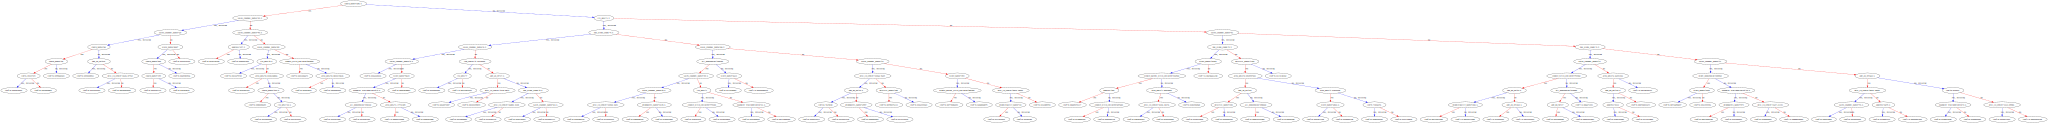

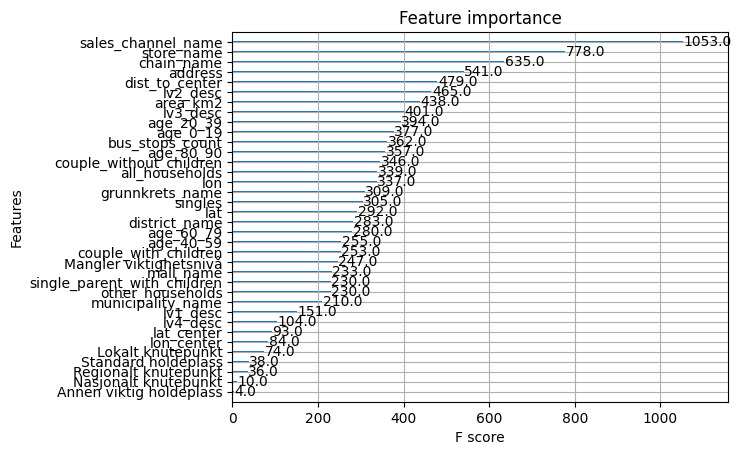

In [40]:
plot_importance(model)
xgb.to_graphviz(model, num_trees=1)